# ITI110 Project - Speaker Recognition

Team 9

## Part 3 - Modelling

In [0]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
from shutil import copyfile
import matplotlib.pyplot as plt
import imageio
%matplotlib inline

import cv2
import time

import multiprocessing

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import initializers

import numpy.random as rng

### Colab Operations

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#!ls /content/drive/My\ Drive/

### Folder Paths

In [0]:
#base_folder = "/content/drive/My Drive/AIProject/SpeakerRecognition/TIMIT/"
#data_folder = base_folder + "/data"
#train_audio_folder = base_folder + "/Audio/TRAIN/"
#test_audio_folder = base_folder + "/Audio/TEST/"
#save_path = '/content/drive/My Drive/AIProject/SpeakerRecognition/data/'
#output_folder = base_folder + "/npydata/"
#model_path = '/content/drive/My Drive/AIProject/SpeakerRecognition/Weights/'

In [0]:
base_folder = "/home/ubuntu/notebooks/sdaai-pdc2-students/iti110/SpeakerRecognition/"
data_folder = base_folder + "/data"
save_path =  base_folder + 'data/'
train_audio_folder = base_folder + "/Audio/TRAIN/"
test_audio_folder = base_folder + "/Audio/TEST/"
output_folder = base_folder + "/npydata/"
model_path = '/home/ubuntu/notebooks/sdaai-pdc2-students/iti110/SpeakerRecognition/Weights/'

# Modelling

### Model and Weight and Biases Initialization

In [0]:
def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [0]:
def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

## Define single model

In [0]:
def get_base_conv_encoder(input_shape):
     # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape,
                     kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), kernel_regularizer=l2(2e-4)))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3,3), activation='relu',
                     kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(516, activation='sigmoid',
                    kernel_regularizer=l2(1e-3),
                    kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),bias_initializer=initialize_bias))
    return model
    

## Define Siamese Network and Distance Calculations

In [0]:
def build_final_model(input_shape,  distance_metric='uniform_euclidean'):
    
    assert distance_metric in ('uniform_euclidean', 
                                'weighted_l1',
                                'cosine_distance')
    
    # create left and right network
    #
    left_input = Input(input_shape)  
    right_input = Input(input_shape)
    model = get_base_conv_encoder(input_shape)
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Weighted L1
    #
    if distance_metric == 'weighted_l1':
        print("using Weighted_l1")
        L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
        L1_distance = L1_layer([encoded_l, encoded_r])
        prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
      
    # Euclidian 
    #
    if distance_metric == 'uniform_euclidean':
        print("inside euclidian")
        L1_layer = Lambda(lambda tensors:K.sqrt(K.sum(K.square(K.abs(tensors[0] - tensors[1])),axis=-1, keepdims=True)))
        L1_distance = L1_layer([encoded_l, encoded_r])
        prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)

    # Cosine Distance 
    #
    if distance_metric == 'cosine_distance':
        print("using cosine similarity")
        L1_layer = Lambda(cosine_similarity, output_shape=cos_dist_output_shape)
        L1_distance = L1_layer([encoded_l, encoded_r])
        prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net  

## Loss Functions

In [0]:
from tensorflow.keras import backend as K

def cosine_similarity(vectors):
    #tf.print("COS:")
    x, y = vectors
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    #tf.print("COS:", -K.mean(x * y, axis=-1, keepdims=True))
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)


## Build Model

In [0]:
model = build_final_model((188, 40, 1),'weighted_l1')
model.summary()

using Weighted_l1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 188, 40, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 188, 40, 1)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 516)          23852804    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 516)          0           sequential[

### Compile Model

In [0]:
# Set Optimizer
optimizer = Adam(lr = 0.00006)

# Comple
model.compile(loss="binary_crossentropy",metrics=['accuracy'], optimizer=optimizer)


# Build Tensors


## Load Training Tensors

In [0]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
#print("Training Person IDs: \n")
#print(list(train_classes.keys()))

## Load Validation Tensors

In [0]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xtest, test_classes) = pickle.load(f)
#print("Validation alphabets:", end="\n\n")
#print(list(test_classes.keys()))

In [0]:
print(Xtest.shape)

(168, 10, 188, 40)


## Random Pairs Generator

In [0]:
def generate_rnd_pairs(numofcategories=2, s = 'train'):
    
    if s == 'train':
            X = Xtrain
    else:
            X = Xtest
    n_classes, n_samples, w, h = X.shape
    categories = rng.choice(n_classes,size=(numofcategories,),replace=False)

    batchsize = numofcategories * numofcategories * X.shape[1] * X.shape[1]

    pairs=[np.zeros((batchsize , w, h,1)) for i in range(2)]

    targets=np.zeros((batchsize,))
    outercounter = X.shape[0]
    innercounter = X.shape[0]
    
    sample = 0
    for i in range(numofcategories):
        category_1 = categories[i]

        for idx1 in range(X.shape[1]):
            for j in range(numofcategories):
                category_2 = categories[j]
                for idx2 in range(X.shape[1]):
                    pairs[0][sample,:,:,:] = X[category_1, idx1].reshape(w, h, 1)
                    pairs[1][sample,:,:,:] = X[category_2, idx2].reshape(w, h,1)
                    if category_1 == category_2:
                        targets[sample] = 1
                    sample = sample + 1
                    
    return pairs, targets

In [0]:
def generate_rnd_samples(numofcategories=1, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = generate_rnd_pairs(numofcategories,s)
        yield (pairs, targets)

# Train Model

##Define Callbacks and Set HyperParameters

In [0]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path + '/seg_' +  
            'weights.best.hdf5',
        monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
]

In [0]:
# Hyper parameters
#evaluate_every = 200 # interval for evaluating on one-shot tasks
evaluate_every = 1
batch_size = 3
epochs = 20
stepsforepoch = 32
#n_iter = 20000 # No. of training iterations
n_iter = 10 # No. of training iterations
N_way = 20 # how many persons for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [0]:
model_path = '/home/ubuntu/notebooks/sdaai-pdc2-students/iti110/SpeakerRecognition/Weights/'

### Run Training

In [0]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
history_list = []
for i in range(n_iter):
    print("Iteration # : " , i)
    
    history = model.fit_generator(generate_rnd_samples(batch_size), 
                                  steps_per_epoch=stepsforepoch, 
                                  epochs=epochs,
                                  verbose=1,
                                  callbacks=callbacks_list, 
                                  validation_data=generate_rnd_samples(2,'val'),
                                  validation_steps=10, 
                                  validation_freq=1)
  
    history_list.append(history)


Starting training process!
-------------------------------------
Iteration # :  0
Epoch 1/20
32/32 [==============================] - 49s 2s/step - loss: 2.8532 - accuracy: 0.3876 - val_loss: 2.5498 - val_accuracy: 0.5000
Epoch 2/20
32/32 [==============================] - 44s 1s/step - loss: 2.1732 - accuracy: 0.6832 - val_loss: 2.1336 - val_accuracy: 0.5000
Epoch 3/20
32/32 [==============================] - 44s 1s/step - loss: 1.7526 - accuracy: 0.7076 - val_loss: 1.7835 - val_accuracy: 0.5000
Epoch 4/20
32/32 [==============================] - 44s 1s/step - loss: 1.4574 - accuracy: 0.7364 - val_loss: 1.5335 - val_accuracy: 0.5065
Epoch 5/20
32/32 [==============================] - 45s 1s/step - loss: 1.2320 - accuracy: 0.7299 - val_loss: 1.2095 - val_accuracy: 0.8475
Epoch 6/20
32/32 [==============================] - 45s 1s/step - loss: 1.0323 - accuracy: 0.7793 - val_loss: 1.0741 - val_accuracy: 0.7690
Epoch 7/20
32/32 [==============================] - 45s 1s/step - loss: 0.9387

NameError: name 'display_training_loss_and_accuracy' is not defined

# Performance Metrics

### Training Graphs: Accuracy & Loss

In [0]:
def display_training_loss_and_accuracy(iteration, history):
    
    title1 = 'model accuracy for iteration :' + str(iteration)
    title2 = 'model loss for iteration :' + str(iteration)
    plt.figure(figsize=(20,4))
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epoch_count,history.history['accuracy'])
    plt.plot(epoch_count,history.history['val_accuracy'])
    plt.title(title1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(epoch_count,history.history['loss'])
    plt.plot(epoch_count,history.history['val_loss'])
    plt.title(title2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()    

{'loss': [2.8532061502337456, 2.173150610178709, 1.7525507733225822, 1.4574028216302395, 1.2320375889539719, 1.032252799719572, 0.9387352764606476, 0.7942184675484896, 0.6917314454913139, 0.6572664994746447, 0.6051786541938782, 0.5580170145258307, 0.5830288119614124, 0.5382948163896799, 0.5216044103726745, 0.48227828461676836, 0.48153890296816826, 0.500195519067347, 0.5044394005089998, 0.49145936500281096], 'accuracy': [0.3876389, 0.68322915, 0.70763886, 0.73638886, 0.72986114, 0.77934027, 0.7426389, 0.79368055, 0.81416667, 0.7979514, 0.8076389, 0.8252083, 0.77826387, 0.80930555, 0.79506946, 0.82416666, 0.82, 0.7959028, 0.791875, 0.79715276], 'val_loss': [2.5497764110565186, 2.133590579032898, 1.783464741706848, 1.5334823489189149, 1.209458839893341, 1.0740675806999207, 0.9836253523826599, 0.7304971039295196, 0.7688452482223511, 0.6847308337688446, 0.6942522466182709, 0.5347501188516617, 0.6640839755535126, 0.5694580048322677, 0.510730904340744, 0.49809948801994325, 0.5330023825168609,

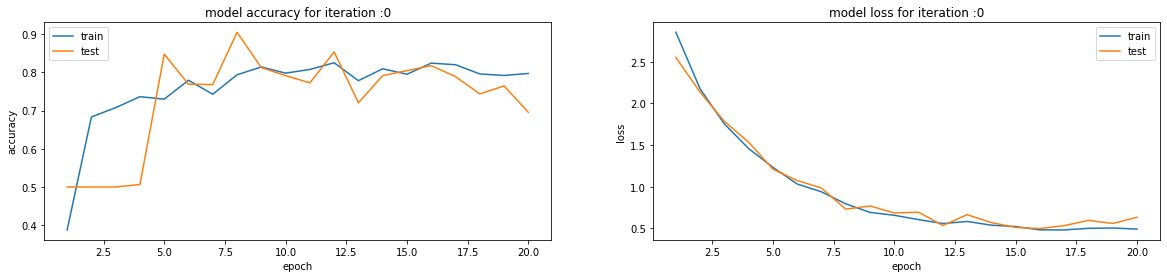

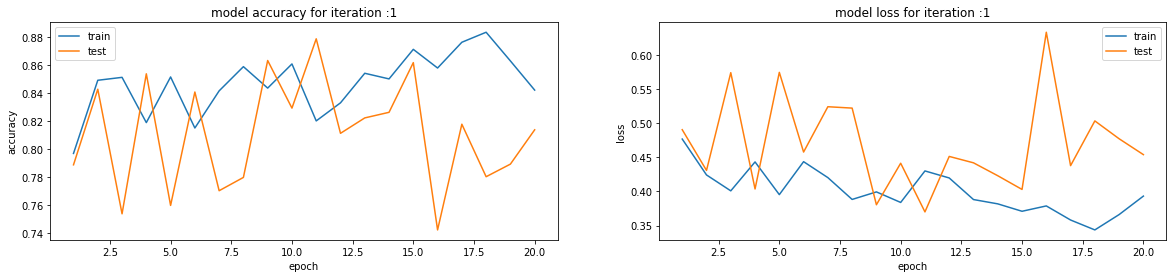

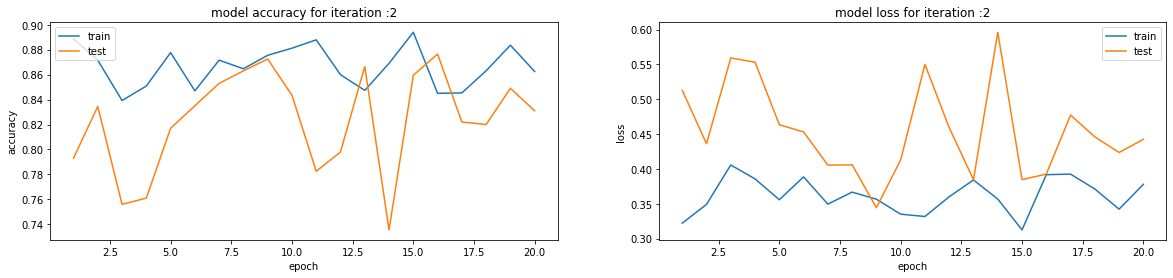

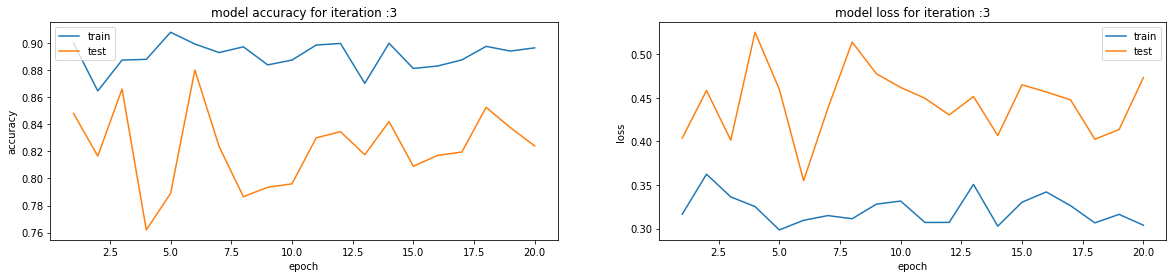

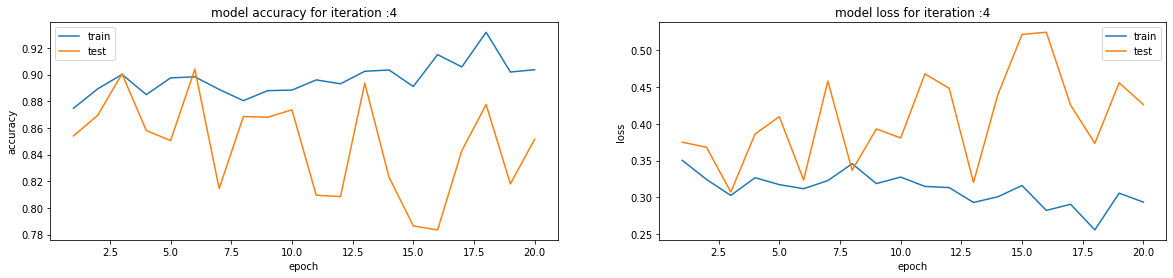

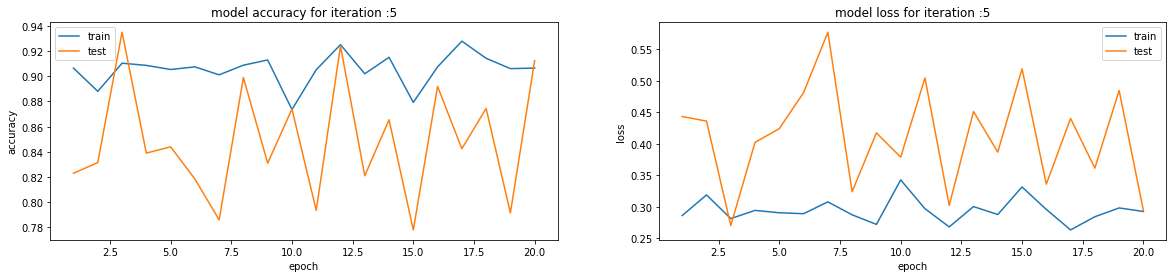

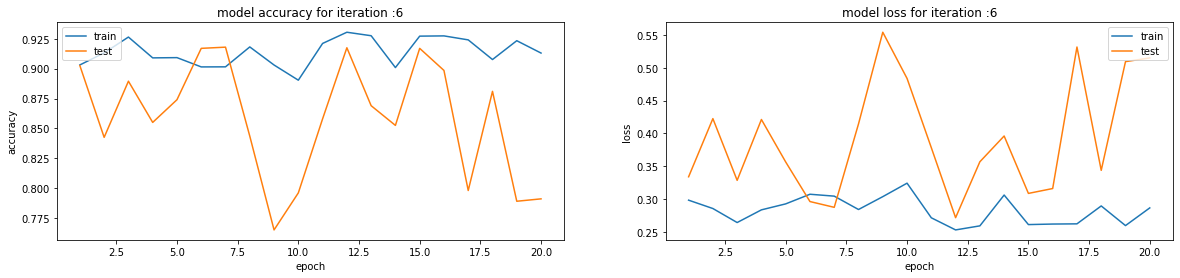

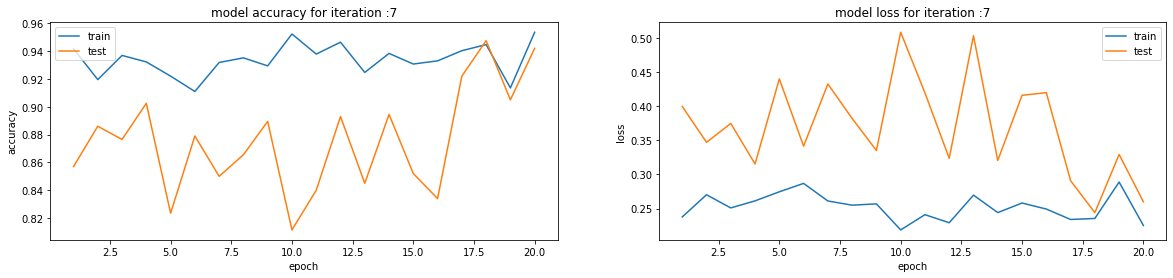

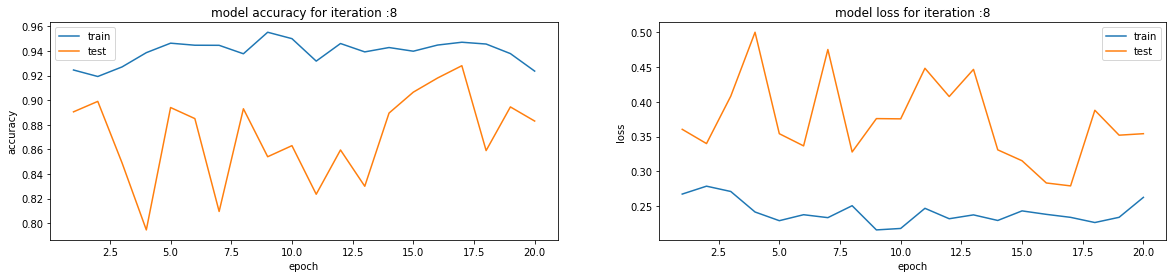

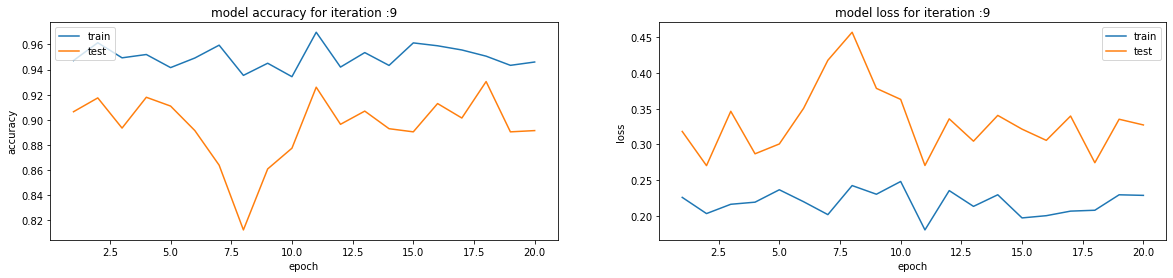

In [0]:
print(history_list[0].history)
for i in  range(len(history_list)):
     history = history_list[i]
     display_training_loss_and_accuracy(i, history)

### Chart AUC

In [0]:
# Load model weights with trained model weights
model.load_weights(os.path.join(model_path, "seg_weights.best.hdf5"))

In [0]:
from sklearn.metrics import roc_curve
(X_test, y_test) = generate_rnd_pairs(numofcategories=2, s="val")
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [0]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

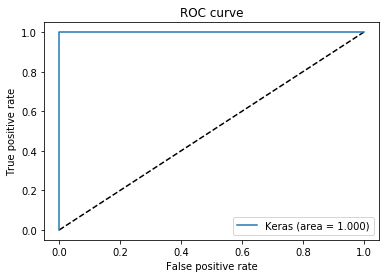

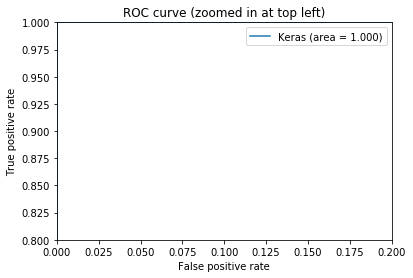

In [0]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()